In [1]:
# Imports
from typing import List, Dict, Tuple, Callable, Union
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
from seaborn import pairplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Initial Process Data

df_bank_main = pd.read_csv("bank-full.csv", sep=";")
data_length = 5200
np.random.seed(42)

accuracy_scores = []

# function to make sure we have an equal number of yes and no samples
def getEqual(x, X, y):
    # Get a random even split of x yes's and no's
    no_index = y[y == 0].index
    yes_index = y[y == 1].index
    # Get a list of random x indexes
    selected_no = np.random.choice(no_index, size=x, replace=False)
    selected_yes = np.random.choice(yes_index, size=x, replace=False)

    # recombine the lists
    X = pd.concat([X.iloc[selected_no], X.iloc[selected_yes]], axis=0, ignore_index=True)
    y = pd.concat([y[selected_no], y[selected_yes]], ignore_index=True)
    return X, y

# get the cleaned data
def getData():
    # We will be using duration, age, balance, campaign, previous
    # Simply because they have no missing values
    df_bank = df_bank_main.copy(deep=True)
    X = df_bank[['duration', 'age', 'balance', 'campaign', 'previous', 'loan', 'default']]
    y = df_bank["y"]

    # Change loan to int values
    intMap = {'no': -1, 'yes': 1}
    X.loc[:, 'loan'] = X['loan'].map(intMap)

    # Change default to int values
    X.loc[:, 'default'] = X['default'].map(intMap)
    
    # Change target from str/object to int
    # no = 0 | yes = 1
    intMap = {'no': 0, 'yes': 1}
    y = y.map(intMap)

    # Return X (data) and y (targets)
    # get even number of each target:
    X, y = getEqual(data_length, X, y)
    X = X.astype(np.int64)
    return X, y

X, y = getData()
#display(X)
#display(y)

y
1    84
0    66
Name: count, dtype: int64


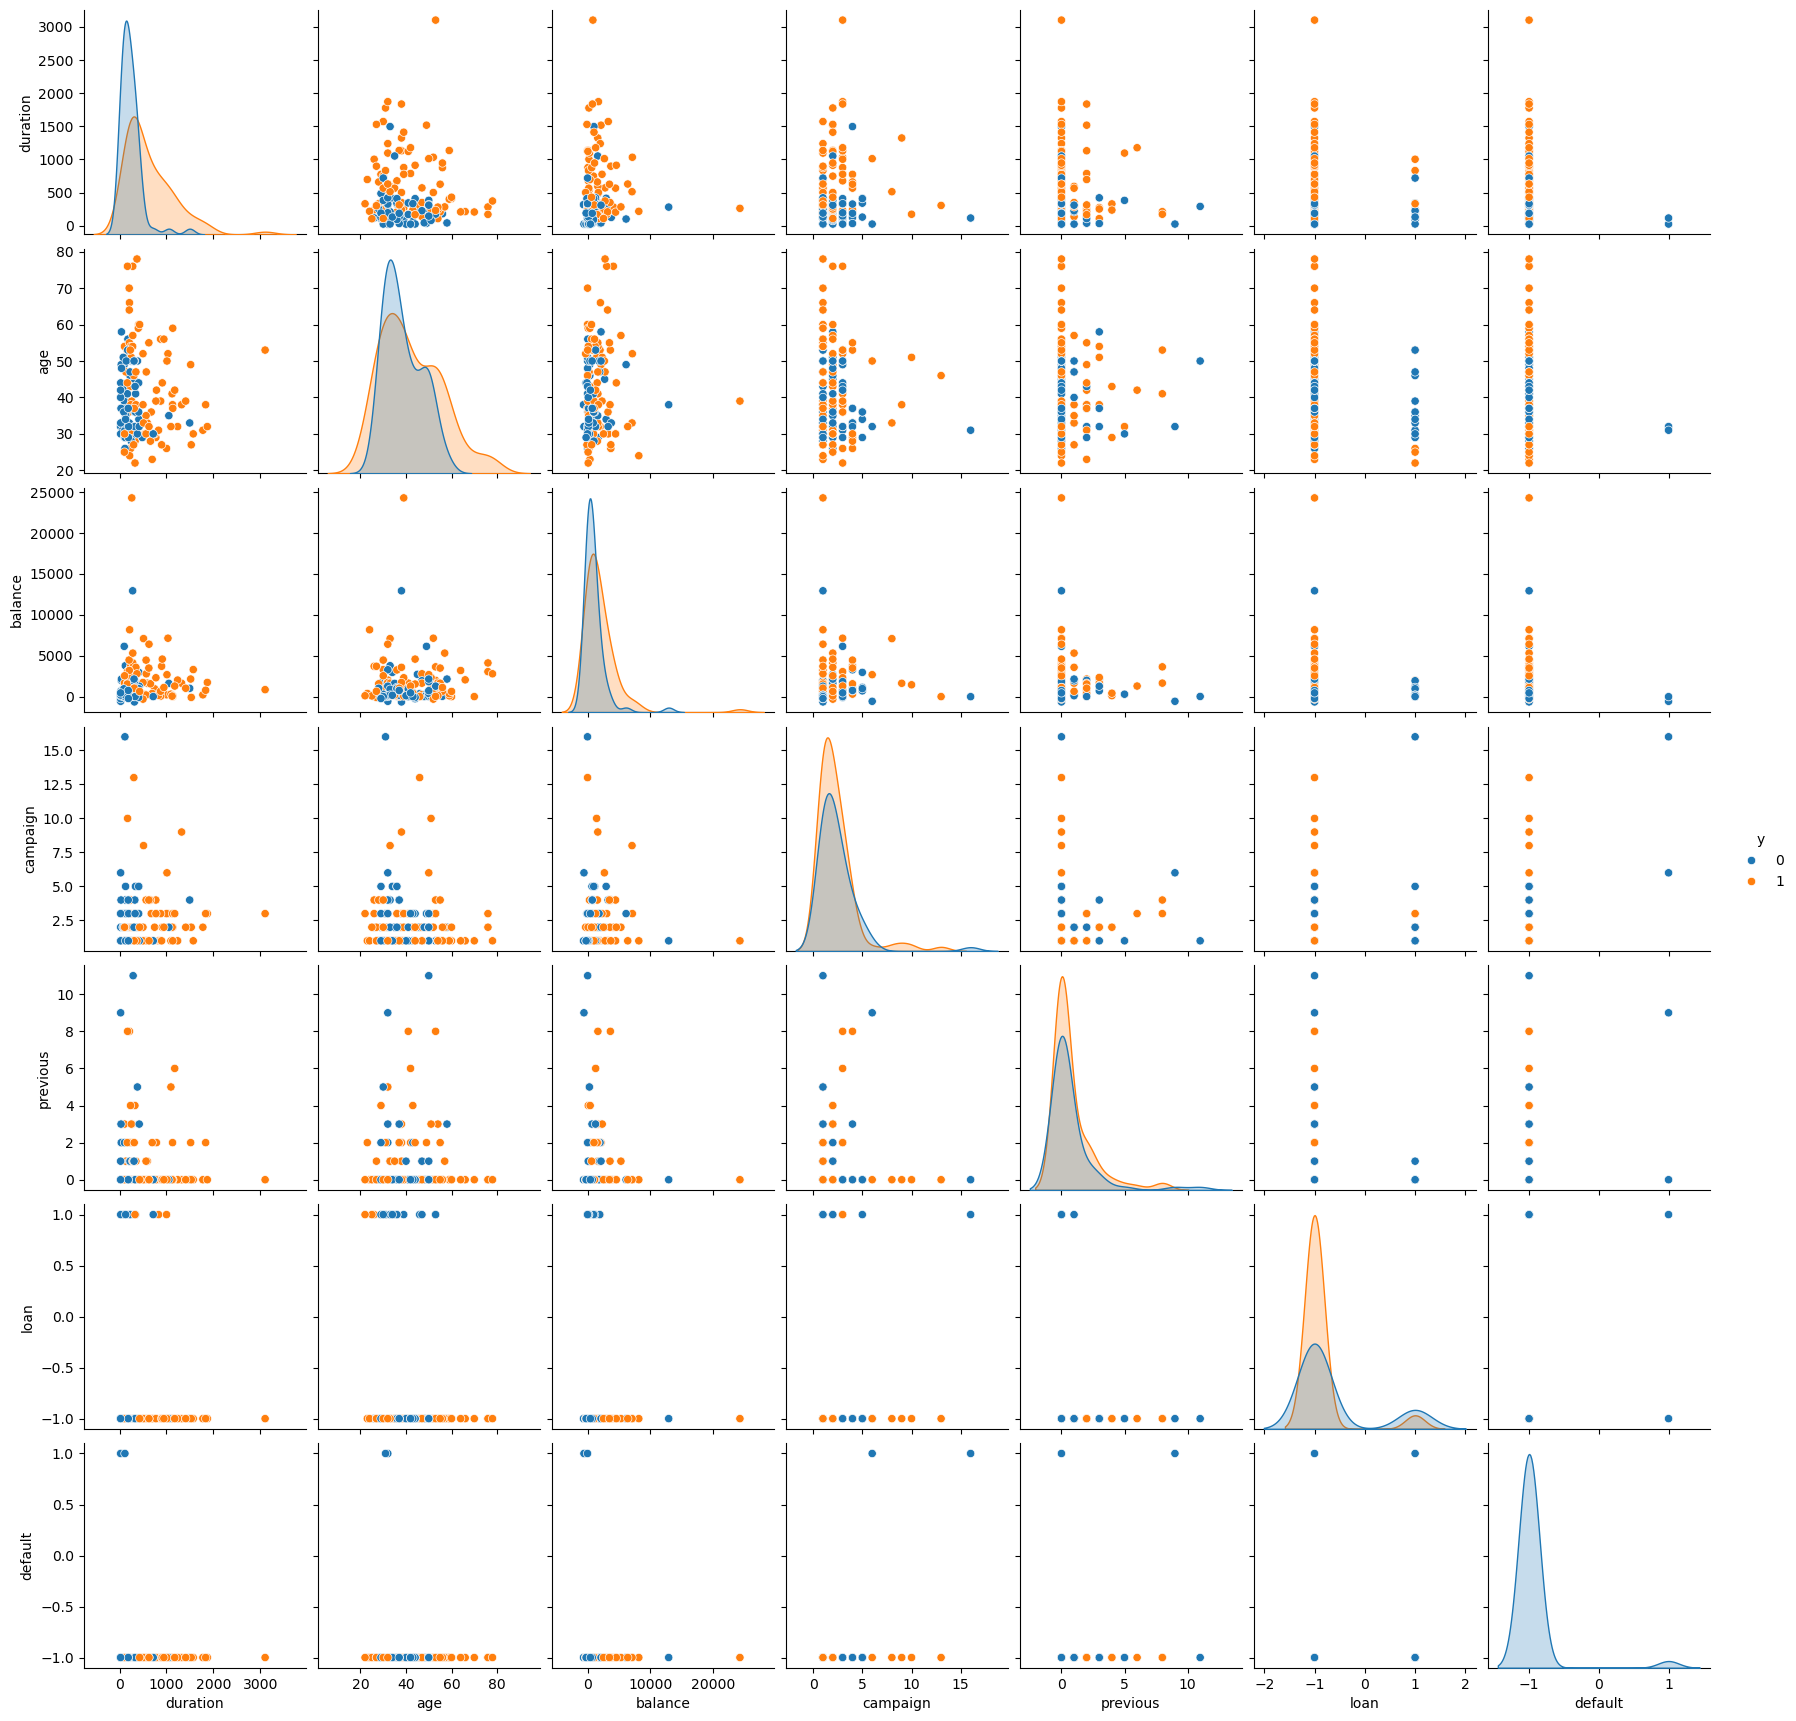

In [3]:
# Classification Data Visualization

X, y = getData()

# No need to plot all the data, just pick a random sample of 150
indices = np.arange(len(y))
np.random.shuffle(indices)
X_select = X.iloc[indices[:150]]
y_select = y[indices[:150]]

print(y_select.value_counts())
df_visualize = pd.concat([X_select, y_select], axis=1)
pairplot(df_visualize, hue="y")


In [4]:
# Data Pre-processing for KNN
# Wow, little to no code, nice
def get_preprocessed_data_KNN():
    X, y = getData()
    X_trn, X_tst, y_trn, y_tst = train_test_split(X.values, y.values, train_size=.8, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)
    return X_trn, X_tst, y_trn, y_tst

In [5]:
# KNN Machine Learning Code
# Taken from previous assignment
def accuracy_knn(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the accuracy between two 1D vectors

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Return:
            A float corresponding to the accuracy
    """
    y =  y.reshape(-1,) # reshape to make 1D vector for consistency
    y_hat = y_hat.reshape(-1,) # reshape to make 1D vector for consistency

    # TODO 7.1
    are_same = y == y_hat
    
    
    # TODO 7.2
    total_correct = np.sum(are_same)
    
    
    # TODO 7.3
    total_samples = len(y)
    
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    
    # TODO 7.4
    
    return total_correct / total_samples

def euclidean_distance(x: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """ Compute the euclidean distance between a row vectors or a vecotr and a matrix.
        Args:
            x: The 1st NumPy array given as a 1D vector or 2D row vector

            Y: The 2nd NumPy array given as a 2D row vector or 2D matrix

        Return:
            A 1D vector of flaots representing the distance between x and Y
    """
    assert len(Y.shape) == 2, f"y is a 1D vector, expected 2D row vector or matrix"
    # TODO 6
    squared_elements = (x - Y)**2
    summed_columns = np.sum(squared_elements, axis=1)
    distance = np.sqrt(summed_columns)
    
    
    
    return distance

class KNearestNeighbors():
    """
        Attributes:
            k: Number of nearest neighbors

            distance_measure: A python function reference which will compute a valid distance measure

            X: The training input features

            y: The training targets/labels
    """
    def __init__(self, k: int, distance_measure: Callable):
        """
            Args:
                k: Number of nearest neighbors

                distance_measure: A python function that computes a distance measure
        """
        self.k = k
        self.distance_measure = distance_measure
        self.X: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """ Stores the training data for comparison 

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 1D vector
        """
        # TODO 8.1
        self.X = X
        self.y = y
        

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Performs KNN using stored training data

            Args:
                X: Testing data given as a 2D matrix

            Return:
                Returns a 1D vector of predictions for each data sample in X
        """
        y_hats: list = []
        # TODO 8.2
        for x in X:
        
            # TODO 8.3
            distances = self.distance_measure(x, self.X)
            # TODO 8.4
            indices = np.argsort(distances)[:self.k]
            # TODO 8.5
            nearest_labels = self.y[indices]
            # TODO 8.6
            count = np.bincount(nearest_labels)
            # TODO 8.7
            y_hats.append(np.argmax(count))
            
        # TODO 8.8
        y_hats = np.array(y_hats)
        return y_hats

In [6]:
# KNN Testing Code
#indices = np.arange(data_len)
#np.random.shuffle(indices)
#batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]
X_trn, X_tst, y_trn, y_tst = get_preprocessed_data_KNN()
knn = KNearestNeighbors(k=200, distance_measure=euclidean_distance)
# Train KNN
knn.fit(X_trn, y_trn)
# Compute test predictions
y_hat = knn.predict(X_tst)
print(f"Predictions: {y_hat}")

# Compute test accuracy
test_acc = accuracy_knn(y=y_tst, y_hat=y_hat)
print(f"Test accuracy: {test_acc:.2f}")

accuracy_scores.append(f"KNN Test accuracy: {test_acc}")

Predictions: [0 1 0 ... 1 0 0]
Accuracy ratio: 1595/2080
Test accuracy: 0.77


In [7]:
# Data Pre-processing for Perceptron
# Wow, lots of code
def binarize_classes(
    X: np.ndarray,
    y: np.ndarray,
    pos_class: List[int], 
    neg_class: List[int]
) -> Tuple[np.ndarray, np.ndarray]:
    """ Converts data into a one-vs-all or one-vs-one prolbem
        according to labels passed as pos or neg.

        Args:
            X: Input data given as matrix

            y: Labels corresponding to input data given as 1D vector

            pos_class: list of labels that will be used for 
                the positive class.

            neg_class: list of labels that will be used for 
                the negative class.

        Returns:
            Two arrays where the 1st corresponds to the data
            given as a matrix and the 2nd corresponds to the
            new labels given as a 1D vector.
    """
    X = X.copy()
    y = y.copy()

    # TODO 2.1
    indexes = [i for i in range(len(y)) if y[i] in pos_class]
    X_pos, y_pos = X[indexes], [1 for i in range(len(indexes))]
    
    # TODO 2.2
    indexes = [i for i in range(len(y)) if y[i] in neg_class]
    X_neg, y_neg = X[indexes], [-1 for i in range(len(indexes))]
    
    
    return np.vstack([X_pos, X_neg]), np.hstack([y_pos, y_neg])
    
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst
    
def get_preprocessed_data_Perceptron():
    X, y = getData()
    X, y = binarize_classes(
        X=X.values, 
        y=y.values, 
        pos_class=[1], # positive class is yes/1
        neg_class=[0]  # negative class is no/0
    )
    
    # TODO 3.2
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= get_train_valid_test_data(X, y)
    

    # TODO 3.3
    scaler = StandardScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)
    
    # TODO 3.4
    bias = np.array([[1] for i in range(len(X_trn))])
    X_trn = np.concatenate((bias, X_trn), axis=1)
    bias = np.array([[1] for i in range(len(X_tst))])
    X_tst = np.concatenate((bias, X_tst), axis=1)
    bias = np.array([[1] for i in range(len(X_vld))])
    X_vld = np.concatenate((bias, X_vld), axis=1)
    

    # Reshape targets to be 2D column vectors
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

#Code for plotting confusion matrix
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_name_key: Dict[int, str] = None
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_name_key: A dictionary where each key corresponds to 
                a label in y and the values corresponding to string name 
                for said label. This name will be displayed when plotting.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    # TODO 5
    cfm = confusion_matrix(y, y_hat)
    
    
    labels = np.sort(np.unique(y))
    if class_name_key is not None:
        classes = []
        for l in labels:
            class_name = class_name_key.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True)

    return cfm_df

In [8]:
# Perceptron machine learning class
def accuracy_perceptron(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the accuracy between two 1D vectors

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Return:
            A float corresponding to the accuracy
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency

    # TODO 4
    total = len(y)
    sum = 0
    for i in range(total):
        if y[i] == y_hat[i]:
            sum += 1
    accuracy = sum / total
    
    return accuracy

class Perceptron():
    """ Performs binary classification using Rosenblatt's perceptron
    
        Attributes:

            alpha: learning rate or step size
 
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: Vector of weights 

            trn_acc: List that stores training accuracy for each epoch.

            vld_acc: List that stores validation accuracy for each epoch.
    """
    def __init__(
        self, 
        alpha: float,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_acc = None
        self.vld_acc = None

    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Train the perceptron to find optimal weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        np.random.seed(self.seed) # Set seed for reproducibility
        self.trn_acc = []
        self.vld_acc = []
        # TODO 9.1 - 9.2
        
        self.w = np.random.rand(len(X[0]), 1)
        
        for e in range(self.epochs):
            misclassified = 0

            for m in range(len(X)):
                x_m = X[[m]].T
                z = self.w.T @ x_m
                y_hat = np.sign(z)
                
                if y_hat != y[m]:
                    misclassified += 1
                    self.w = self.w + self.alpha * y[m] * x_m

            #---------------------------------------------------
            trn_preds = self.predict(X)
            trn_acc = accuracy_perceptron(y, trn_preds)
            self.trn_acc.append(trn_acc)
            
            if X_vld is not None and y_vld is not None:
                vld_preds = self.predict(X_vld)
                vld_acc = accuracy_perceptron(y_vld, vld_preds)
                self.vld_acc.append(vld_acc)
            #---------------------------------------------------
            
            if misclassified == 0:
                break
                
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        # TODO 9.3
        
        return np.sign(X @ self.w)

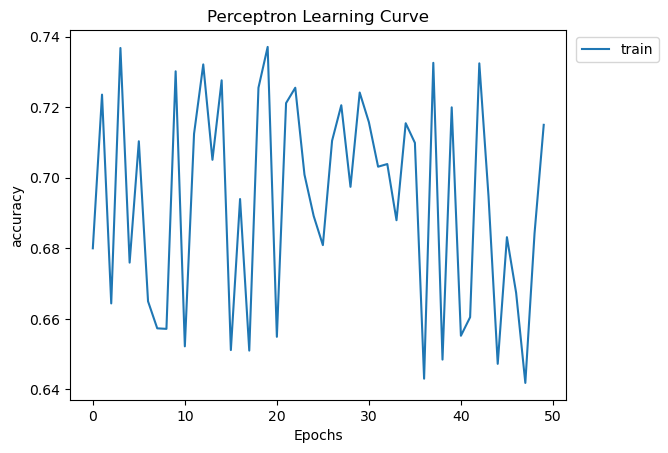

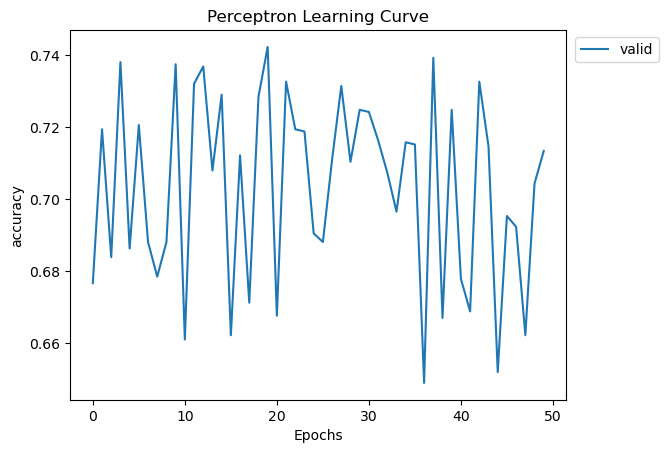

Test Accuracy: 0.7144230769230769


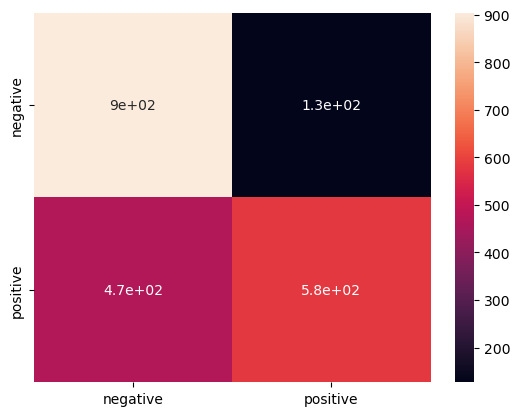

In [9]:
# Perceptron testing
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data_Perceptron()
perceptron = Perceptron(alpha=.25, epochs=50, seed=42)
perceptron.fit(
    X=X_trn, 
    y=y_trn, 
    X_vld=X_vld, 
    y_vld=y_vld
)

# Learning curve
plt.plot(perceptron.trn_acc, label='train')
plt.title("Perceptron Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(bbox_to_anchor=(1.2, 1.00))
plt.show()
plt.plot(perceptron.vld_acc, label='valid')
plt.title("Perceptron Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(bbox_to_anchor=(1.2, 1.00))
plt.show()

# Display the accuracy, TPR, TNR, and PPV, metrics for, at least, the testing data.
y_hat = perceptron.predict(X_tst)
y = y_tst

accuracy_tst = accuracy_perceptron(y=y, y_hat=y_hat)
print(f"Test Accuracy: {accuracy_tst}")

accuracy_scores.append(f"Perceptron Test Accuracy: {accuracy_tst}")

# Plot confusion matrix
cfm = plot_confusion_matrix(
    y=y, 
    y_hat=y_hat, 
    class_name_key={
        -1: 'negative',
        1: 'positive'
    }
)
plt.show()

In [10]:
# Naive-Bayes Preprocessing
def get_preprocessed_data_NaiveBayes() -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing
        Args:
            drop_features: List of feature names to drop from iris.data.
            
        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X, y = getData()
    
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X.values, y.values)
    # Reshape targets to be 2D column vectors
    scaler = StandardScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [11]:
# Naive-Bayes Machine Learning
def compute_log_priors(y: np.ndarray) -> np.ndarray:
    """ Computes the log priors for each class
    
        Args:
            y: The labels/tagets given as a vector. 

        Returns:
            1D vector of log priors for each class in ascending order labels.
    """
    # TODO 3
    values, counts = np.unique(y, return_counts=True)
    newArr = [0] * len(values)
    for i in range(len(values)):
        newVal = float(counts[i]) / float(len(y))
        newArr[i] = newVal
    newArr = np.log(newArr)
    return newArr

def log_gaussian(
    x: np.ndarray, 
    mu: Union[np.ndarray, float], 
    sigma: Union[np.ndarray, float],
) -> np.ndarray:
    """ Computes the value at a given point in a Gaussian distribution
    
        Args:
            x: Data given as a NumPy a matrix or vector.
            
            mu: Feature means given as a NumPy vector or float.
            
            sigma: Feature standard deviations given as a NumPy vector or float.
            
        Returns:
            A NumPy array of feature log liklihoods equal to the shape of x.
    """
    # TODO 4
    retVal = (-1 / 2) * (np.log(np.power(sigma, 2) * 2 * np.pi) + np.power((x - mu) / sigma, 2))
    return retVal

def compute_parameters(
    X: np.ndarray, 
    y: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """ Computes the means and standard deviations for classes and features
    
        Args:
            X: Data given as a 2D matrix 
            
            y: Labels given as a 2D column vector

        Returns:
            Two NumPy arrays corresponding to the mean and STDs for each class and feature,
            such that each array has the shape (|K|, N).
    """
    means = []
    stds = []
    K = np.unique(y)
    # TODO 5
    for k in K:
        indices = np.where(y == k)[0]
        class_label = X[indices]
        feature_means = np.mean(class_label, axis=0)
        means.append(feature_means)
        feature_std = np.std(class_label, axis=0)
        stds.append(feature_std)
    
    return np.array(means), np.array(stds)

def compute_log_likelihoods(X, means, stds, verbose=True):
    """ Computes the log likelihoods for all classes and data samples
    
        Args:
            X: Data to compute log likelihoods given as a matrix.
            
            means: Means for each class and feature of shape (|K|, N).
            
            stds: Standard deviations for each class and feature of shape (|K|, N).

        Returns:
            NumPy matrix containing ALL class log likelihoods with shape (M, |K|) where
            M is the number of data samples in the passed data X and |K| is the number 
            of classes given by the number of rows in means and stds.
    """
    log_likelihoods = []
    # TODO 6
    for mean, std in zip(means, stds):
        feature_log_likelihoods = log_gaussian(X, mean, std)
        class_log_likelihoods = np.sum(feature_log_likelihoods, axis=1)
        log_likelihoods.append(class_log_likelihoods)
    return np.array(log_likelihoods).T

class GaussianNaiveBayes():
    """ Performs multi-classifcation using Gaussian Naive Bayes

        Attributes:
            log_priors: The log of the priors computed based on the training data 

            means: The means for each class and every feature with shape (|K|, N).

            stds: The standard deviations for each class and every feature 
                with shape (|K|, N).
    """
    def __init__(self):
        self.log_priors = None
        self.means = None
        self.stds = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        """ Compute the log_priors, means, and STDs using training data.
        
            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        # TODO 7
        self.log_priors = compute_log_priors(y)
        self.means, self.stds = compute_parameters(X, y)
        return self
        
    def predict(self, X: np.ndarray):
        """ Make a prediction using log maximum a posteriori (MAP)
        
            Args:
                X: Data given as a 2D matrix.

            Returns:
                Preductions given as a 2D column vctor.
        """
        # TODO 7
        predVal = compute_log_likelihoods(X, self.means, self.stds) + self.log_priors
        predVal = np.argmax(predVal, axis=1, keepdims=True)
        return predVal

Training Accuracy: 0.7438401442307693


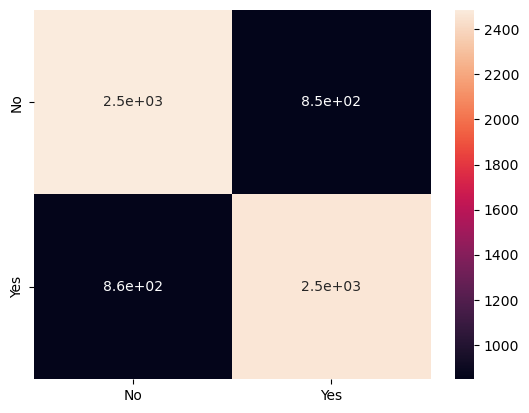

Validation Accuracy: 0.7457932692307693
Testing Accuracy: 0.7322115384615384


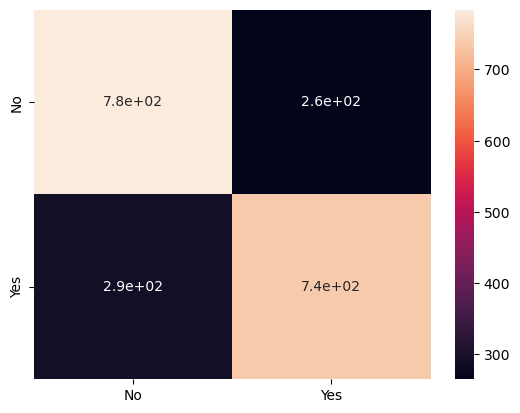

In [12]:
# Testing
class_names = {
        0: 'No',
        1: 'Yes'
    }
#### TODO 8: Training Code
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data_NaiveBayes()


gnb = GaussianNaiveBayes()
gnb.fit(X_trn, y_trn)
y_hat = gnb.predict(X_trn)
acc = accuracy_score(y_trn, y_hat)
print(f"Training Accuracy: {acc}")
plot_confusion_matrix(y=y_trn, y_hat=y_hat, class_name_key=class_names)
plt.show()

y_hat = gnb.predict(X_vld)
acc = accuracy_score(y_vld, y_hat)
print(f"Validation Accuracy: {acc}")

y_hat = gnb.predict(X_tst)
acc = accuracy_score(y_tst, y_hat)
print(f"Testing Accuracy: {acc}")

accuracy_scores.append(f"Naive Bayes Test Accuracy: {acc}")

plot_confusion_matrix(y=y_tst, y_hat=y_hat, class_name_key=class_names)
plt.show()


In [13]:
# Final test accurracies of all machine learning algorithms
for acc in accuracy_scores:
    print(acc)

KNN Test accuracy: 0.7668269230769231
Perceptron Test Accuracy: 0.7144230769230769
Naive Bayes Test Accuracy: 0.7322115384615384
